# Flowsheet Drawing

This notebook extends the flowsheet parser by adding actions to create a directed graph using the `pydot` library, and drawing the result using the `graphviz` package.

### Using with Google CoLaboratory

If using this notebook on Google CoLaboratory, execute the following cell to install the `graphviz` package and `pydot` library.  

In [2]:
!apt-get -qq install -y graphviz
!pip install -q pydot

/bin/sh: apt-get: command not found


## Flowsheet Parsing

The following cell creates `ParserElement` objects using the `pyparsing` library. These implement a simple parser to validate strings representing flowsheets. This notation is based on the SFILES, but with upper case alphabetic characters denoting entire process groups.

In [3]:
from pyparsing import Literal, Word, Group
from pyparsing import Optional, OneOrMore, ZeroOrMore
from pyparsing import alphas, nums
from pyparsing import nestedExpr

GT = Literal(">")
LT = Literal("<")

# process group
processgroup = Word(alphas.upper(), exact=1)
           
# process sequence is comprised of connectors, process group, and recycles                                             
connector = Optional(GT | LT, GT)
recycle = Word(nums, exact=1)
sequence = Group(OneOrMore(connector + (processgroup | recycle )))

# nested branches
branchsequence = Group(OneOrMore(connector + (processgroup | recycle )))
branch = nestedExpr(opener="[", closer="]", content=branchsequence)
branch.setName('branch')

# sfiles expression
sfiles = sequence + ZeroOrMore(branch | sequence)

## Visualizing Flowsheets using Graphviz

The following cell adds parser actions to the parser elements defined above. The actions are triggered by the parser elements, and used to create nodes for each process group, and links for each connector. 

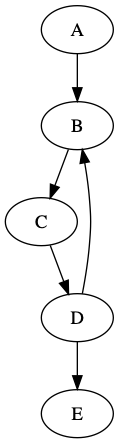

In [4]:
import pydot

graph = pydot.Dot(graph_type='digraph')

lastNode = ['']
lastEdge = ''
recycleSrcs = {}
recycleDsts = {}

def addProcessGroup(t):
    global lastNode, lastEdge
    node = pydot.Node(t[0])
    graph.add_node(node)
    if lastNode[-1] and ('>' in lastEdge):
        graph.add_edge(pydot.Edge(lastNode[-1], node)) 
    elif lastNode[-1] and ('<' in lastEdge):
        graph.add_edge(pydot.Edge(node, lastNode[-1]))
    lastNode[-1] = t[0]
    return t

def addConnector(t):
    global lastEdge
    lastEdge = str(t[0])
    return t

def addRecycle(t):
    global lastEdge, lastNode
    if '<' in lastEdge:
        if t[0] in recycleSrcs.keys():
            src = recycleSrcs[t[0]]
            dst = lastNode[-1]
            graph.add_edge(pydot.Edge(src, dst))
        else:
            recycleDsts[t[0]] = lastNode[-1]
    else:
        if t[0] in recycleDsts.keys():
            src = lastNode[-1]
            dst = recycleDsts[t[0]]
            graph.add_edge(pydot.Edge(src,dst))
        else:
            recycleSrcs[t[0]] = lastNode[-1]
    

# after sequence has been parsed
def addSequence(t):
    global lastNode
    lastNode.append(t[0][-1])
    return t

# after branch sequence has been parsed
def addBranchSequence(t):
    global lastNode
    lastNode.append(t[0][-1])
    return t

def addBranch(t):
    global lastNode
    lastNode.pop(-1)
    lastNode.pop(-1)
    return t
    
processgroup.setParseAction(addProcessGroup)
connector.setParseAction(addConnector)
recycle.setParseAction(addRecycle)
sequence.setParseAction(addSequence)
branchsequence.setParseAction(addBranchSequence)
branch.setParseAction(addBranch)

sfiles.parseString("AB<1CD1E")
from IPython.display import Image
Image(graph.create_png(), retina=True)

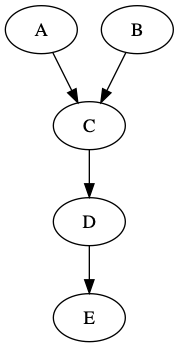

In [5]:
graph = pydot.Dot(graph_type='digraph')

lastNode = ['']
lastEdge = ''
recycleSrcs = {}
recycleDsts = {}

sfiles.parseString("AC[<B]DE")
from IPython.display import Image
Image(graph.create_png(), retina=True)

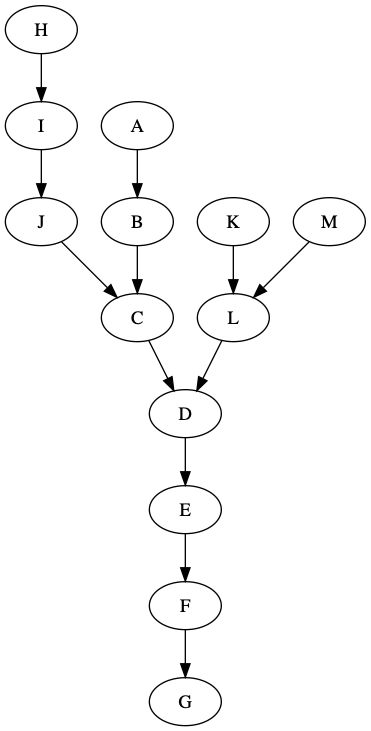

In [6]:
graph = pydot.Dot(graph_type='digraph')

lastNode = ['']
lastEdge = ''
recycleSrcs = {}
recycleDsts = {}

sfiles.parseString("HIJC[<B<A]D[<L[<K]<M]EFG")
from IPython.display import Image
Image(graph.create_png(), retina=True)

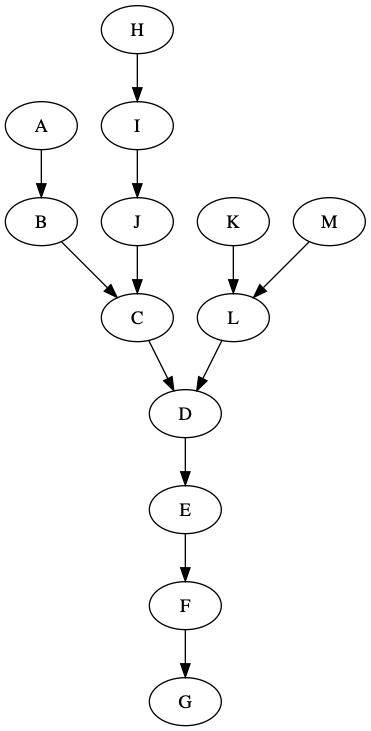

In [7]:
graph = pydot.Dot(graph_type='digraph')

lastNode = ['']
lastEdge = ''
recycleSrcs = {}
recycleDsts = {}
 
sfiles.parseString("ABC[<J<I<H]D[<L[<K]<M]EFG")
from IPython.display import Image
Image(graph.create_png(), retina=True)

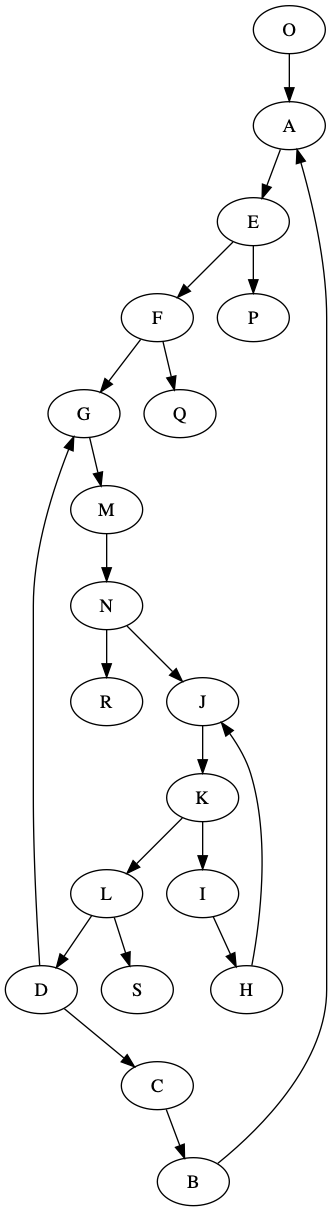

In [8]:
graph = pydot.Dot(graph_type='digraph')

lastNode = ['']
lastEdge = ''
recycleSrcs = {}
recycleDsts = {}
 
sfiles.parseString("OA<1E[P]F[Q]G<2MN[R]J<3K[IH3]L[S]D2CB1")
from IPython.display import Image
Image(graph.create_png(), retina=True)